In [ ]:
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

from sklearn.metrics import f1_score, precision_recall_fscore_support

# Load datasets

## Original data

In [3]:
# Full clean dataset
df_full_clean = pd.read_csv('../F3_Dataset/Full Clean Dataset/F3_Consistency.csv')
print(df_full_clean.shape)
df_full_clean[:3]

(27667, 50)


,uuid,human_content,ai_content,model,num_completion_token,num_original_token,num_prompt_token,num_iagenerated_token,original_label,source_type,...,PaLM_NLI,PaLM_categories,uuid.1,Llama2-Entailment,Llama_NLI,GPT_NLI_plus_ai_label,Llama_NLI_plus_ai_label,PaLM_NLI_plus_ai_label,Logical Consistency,factual_consistency
0,4ac69fef-1574-4a5e-8e85-dccdf2b56f69,"Blake Masters: ""Of course, I support Lindsey G...",🚨BREAKING🚨 Blake Masters just declared his sup...,gpt-3.5-turbo-0301,87,39,178,265,real,AI Machine,...,entailment,"Finance, Health, Legal, Politics, Violent",4ac69fef-1574-4a5e-8e85-dccdf2b56f69,Entailment.\n\nThe statement by Blake Masters ...,entailment,not-entailment_fake,entailment_fake,entailment_fake,inconsistent,consistent
1,346688be-2b10-403d-a8ae-5fe9faed3214,“The Supreme Court has given us an opportunity...,BREAKING: Texas Governor announces new law to ...,gpt-3.5-turbo-0301,67,57,201,268,real,AI Machine,...,not-entailment,"Death, Harm & Tragedy, Health, Legal, Politics...",346688be-2b10-403d-a8ae-5fe9faed3214,Entailment.\n\nThe premise states that the Tex...,entailment,entailment_fake,entailment_fake,not-entailment_fake,inconsistent,consistent
2,8b95e37b-7396-4759-a828-1e128fa59471,Thinking about the many times Justices Gorsuch...,"🚨BREAKING NEWS🚨 Justices Gorsuch, Kavanaugh, a...",gpt-3.5-turbo-0301,71,44,183,254,real,AI Machine,...,entailment,"Legal, Politics, Public Safety, Violent",8b95e37b-7396-4759-a828-1e128fa59471,Not Entailment.\n\nThe premise states that the...,not-entailment,entailment_fake,not-entailment_fake,entailment_fake,inconsistent,consistent


In [4]:
# Create version with just the pre-scoring columns
cols_shared = [
    'uuid', 'label', 'article_type', 'source_type', 'pre_post_GPT',
    'dataset_source', 'Prompt_type',
]
df_gen_wide = df_full_clean.rename(columns={
    'ai_generated_label': 'label',
})[cols_shared + [
    'human_content', 'ai_content',  # -> content
    'num_original_token', 'num_completion_token',  # -> text_length
]]

# Human text
df_gen_human = df_gen_wide.rename(columns={
    'human_content': 'content',
    'num_original_token': 'text_length',
})[cols_shared + ['content', 'text_length']]
df_gen_human.loc[:,'source_type'] = 'human'

# LLM/AI text
df_gen_llm = df_gen_wide.rename(columns={
    'ai_content': 'content',
    'num_completion_token': 'text_length',
})[cols_shared + ['content', 'text_length']]
df_gen_llm.loc[:,'source_type'] = 'LLM'
df_gen_llm.loc[:,'llm_type'] = 'gpt3_5'

df_gen_full_clean = pd.concat([df_gen_human, df_gen_llm])

# All human text is real
df_gen_full_clean.loc[
    (df_gen_full_clean['source_type'] == 'human'), 'label'] = 'real'

df_gen_full_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55334 entries, 0 to 27666
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uuid            55334 non-null  object
 1   label           55334 non-null  object
 2   article_type    55334 non-null  object
 3   source_type     55334 non-null  object
 4   pre_post_GPT    55334 non-null  object
 5   dataset_source  55334 non-null  object
 6   Prompt_type     55334 non-null  object
 7   content         55334 non-null  object
 8   text_length     55334 non-null  int64 
 9   llm_type        27667 non-null  object
dtypes: int64(1), object(9)
memory usage: 4.6+ MB


In [5]:
# Create subsetted version for replication

# Create version with just the pre-scoring columns
cols_shared = [
    'uuid', 'label', 'article_type', 'source_type', 'pre_post_GPT',
    'dataset_source', 'Prompt_type',
]
df_gen_wide = df_full_clean.rename(columns={
    'ai_generated_label': 'label',
})[cols_shared + [
    'human_content', 'ai_content',  # -> content
    'num_original_token', 'num_completion_token',  # -> text_length
]]

df_gen_wide_ss = df_gen_wide.sample(frac=.1, random_state=0)

# Human text
df_gen_human_ss = df_gen_wide_ss.rename(columns={
    'human_content': 'content',
    'num_original_token': 'text_length',
})[cols_shared + ['content', 'text_length']]
df_gen_human_ss.loc[:,'source_type'] = 'human'

# LLM/AI text
df_gen_llm_ss = df_gen_wide_ss.rename(columns={
    'ai_content': 'content',
    'num_completion_token': 'text_length',
})[cols_shared + ['content', 'text_length']]
df_gen_llm_ss.loc[:,'source_type'] = 'LLM'
df_gen_llm_ss.loc[:,'llm_type'] = 'gpt3_5'

df_gen_ss_clean = pd.concat([df_gen_human_ss, df_gen_llm_ss])

# All human text is real
df_gen_ss_clean.loc[
    (df_gen_ss_clean['source_type'] == 'human'), 'label'] = 'real'

df_gen_ss_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5534 entries, 5134 to 1165
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uuid            5534 non-null   object
 1   label           5534 non-null   object
 2   article_type    5534 non-null   object
 3   source_type     5534 non-null   object
 4   pre_post_GPT    5534 non-null   object
 5   dataset_source  5534 non-null   object
 6   Prompt_type     5534 non-null   object
 7   content         5534 non-null   object
 8   text_length     5534 non-null   int64 
 9   llm_type        2767 non-null   object
dtypes: int64(1), object(9)
memory usage: 475.6+ KB


In [7]:
# Newly generated data
models = [
    'gpt3_5',
    'gpt4o',
    'llama2',
]
prompt_types = [
    'Critical',
    'Major',
    'Minor',
]
dfs = []
for model in models:
    for prompt_type in prompt_types:
        try:
            df_real = pd.read_csv(
                f'X_GenPost_{model}_Real_Post_Completed_Data/{prompt_type}_results.csv'
            )
            df_fake = pd.read_csv(
                f'X_GenPost_{model}_Fake_Post_Completed_Data/{prompt_type}_results.csv'
            )

            df_real.loc[:,'Prompt_type'] = prompt_type
            df_fake.loc[:,'Prompt_type'] = prompt_type
            
            df_real.loc[:,'llm_type'] = model
            df_fake.loc[:,'llm_type'] = model

            df_real.loc[:,'ai_generated_label'] = 'real'
            df_fake.loc[:,'ai_generated_label'] = 'fake'
            
            dfs.append(df_real)
            dfs.append(df_fake)
        except FileNotFoundError:
            print(f'model: {model}; prompt_type {prompt_type} not found')
df_new = pd.concat(dfs)

# All human text is real
df_new.loc[:, 'original_label'] = 'real'

print(df_new.shape)
df_new[:3]

(18000, 16)


,uuid,human_written_content,aigenerated_content,model,num_completion_token,num_original_token,num_prompt_token,num_iagenerated_token,original_label,source_type,ai_generated_label,article_type,pre_post_GPT,dataset_source,Prompt_type,llm_type
0,9336c482-793a-4167-ae57-c67d17355381,The shooting of 18-year-old Michael Brown is a...,The fatal shooting of 18-year-old Michael Brow...,gpt-3.5-turbo-0125,349,958,1133,1482,real,AI Machine,real,news article,pre-GPT,FakeNewsNet_Politifacts,Critical,gpt3_5
1,346510d8-e2ad-4d97-801a-c339ac8e0c85,Expanding Opportunity — #KempForum16Let’s get ...,Republican senator Tim Scott and House Speaker...,gpt-3.5-turbo-0125,442,1116,1210,1652,real,AI Machine,real,news article,pre-GPT,FakeNewsNet_Politifacts,Critical,gpt3_5
2,33018c69-3cd5-4971-adc0-d1656645b736,Amid the numerous reports of events in Ukraine...,Recent developments in Crimea have captured th...,gpt-3.5-turbo-0125,377,994,1243,1620,real,AI Machine,real,news article,pre-GPT,FakeNewsNet_Politifacts,Critical,gpt3_5


In [8]:
# Create version with just the pre-scoring columns
cols_shared = [
    'uuid', 'label', 'article_type', 'source_type', 'pre_post_GPT',
    'dataset_source', 'Prompt_type',
]
df_gen_wide = df_new.rename(columns={
    'ai_generated_label': 'label',
})[cols_shared + [
    'human_written_content', 'aigenerated_content',  # -> content
    'num_original_token', 'num_completion_token',  # -> text_length
    'llm_type',
]]

# Human text
df_gen_human = df_gen_wide.rename(columns={
    'human_written_content': 'content',
    'num_original_token': 'text_length',
})[cols_shared + ['content', 'text_length']]
df_gen_human.loc[:,'source_type'] = 'human'

# LLM/AI text
df_gen_llm = df_gen_wide.rename(columns={
    'aigenerated_content': 'content',
    'num_completion_token': 'text_length',
})[cols_shared + ['content', 'text_length', 'llm_type']]
df_gen_llm.loc[:,'source_type'] = 'LLM'

df_gen_new_clean = pd.concat([df_gen_human, df_gen_llm])

# All human text is real
df_gen_new_clean.loc[
    (df_gen_new_clean['source_type'] == 'human'), 'label'] = 'real'

df_gen_new_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uuid            36000 non-null  object
 1   label           36000 non-null  object
 2   article_type    36000 non-null  object
 3   source_type     36000 non-null  object
 4   pre_post_GPT    36000 non-null  object
 5   dataset_source  36000 non-null  object
 6   Prompt_type     36000 non-null  object
 7   content         35959 non-null  object
 8   text_length     36000 non-null  int64 
 9   llm_type        18000 non-null  object
dtypes: int64(1), object(9)
memory usage: 3.0+ MB


In [9]:
# df_gen_new_clean.to_csv('df_gen_new_clean.csv', index=False)

In [10]:
# Create subsetted version for replication

# Create version with just the pre-scoring columns
cols_shared = [
    'uuid', 'label', 'article_type', 'source_type', 'pre_post_GPT',
    'dataset_source', 'Prompt_type',
]
df_gen_wide = df_new.rename(columns={
    'ai_generated_label': 'label',
})[cols_shared + [
    'human_written_content', 'aigenerated_content',  # -> content
    'num_original_token', 'num_completion_token',  # -> text_length
    'llm_type',
]]

df_gen_wide_ss = df_gen_wide.sample(frac=.1, random_state=0)

# Human text
df_gen_human_ss = df_gen_wide_ss.rename(columns={
    'human_written_content': 'content',
    'num_original_token': 'text_length',
})[cols_shared + ['content', 'text_length']]
df_gen_human_ss.loc[:,'source_type'] = 'human'

# LLM/AI text
df_gen_llm_ss = df_gen_wide_ss.rename(columns={
    'aigenerated_content': 'content',
    'num_completion_token': 'text_length',
})[cols_shared + ['content', 'text_length', 'llm_type']]
df_gen_llm_ss.loc[:,'source_type'] = 'LLM'

df_gen_new_ss_clean = pd.concat([df_gen_human_ss, df_gen_llm_ss])

# All human text is real
df_gen_new_ss_clean.loc[
    (df_gen_new_ss_clean['source_type'] == 'human'), 'label'] = 'real'

df_gen_new_ss_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3600 entries, 469 to 318
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uuid            3600 non-null   object
 1   label           3600 non-null   object
 2   article_type    3600 non-null   object
 3   source_type     3600 non-null   object
 4   pre_post_GPT    3600 non-null   object
 5   dataset_source  3600 non-null   object
 6   Prompt_type     3600 non-null   object
 7   content         3598 non-null   object
 8   text_length     3600 non-null   int64 
 9   llm_type        1800 non-null   object
dtypes: int64(1), object(9)
memory usage: 309.4+ KB


In [11]:
# Create one combined generations dataframe
df_gen_all_clean = pd.concat([
    df_gen_ss_clean.assign(experiment='original'),
    df_gen_new_ss_clean.assign(experiment='reproduction'),
])
print(df_gen_all_clean['experiment'].value_counts())
df_gen_all_clean.info()

experiment
original        5534
reproduction    3600
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 9134 entries, 5134 to 318
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uuid            9134 non-null   object
 1   label           9134 non-null   object
 2   article_type    9134 non-null   object
 3   source_type     9134 non-null   object
 4   pre_post_GPT    9134 non-null   object
 5   dataset_source  9134 non-null   object
 6   Prompt_type     9134 non-null   object
 7   content         9132 non-null   object
 8   text_length     9134 non-null   int64 
 9   llm_type        4567 non-null   object
 10  experiment      9134 non-null   object
dtypes: int64(1), object(10)
memory usage: 856.3+ KB


In [57]:
df_gen_all_clean['Prompt_type'].value_counts()

Prompt_type
major       1930
minor       1878
critical    1726
Minor       1234
Critical    1184
Major       1182
Name: count, dtype: int64

## Detection results

In [12]:
# Load all detection results on the original authors' data
models = [
    'gpt3_5',
    'gpt4o',
    'llama2',
    'llama3',
    'mixtral',
]
seeds = [0]
dfs = []
for model in models:
    for seed in seeds:
        df_ = pd.read_csv(f'bkp_{model}_seed_{seed}/progress.csv')
        df_.loc[:,'detection_model'] = model
        df_.loc[:,'detection_seed'] = seed
        if model == 'gpt4o':
            # Clean up mislabelled column
            df_ = df_.rename(columns={'GPT3_5T-label': 'GPT4o-label'})
        dfs.append(df_)
del df_
df_results_orig = pd.concat(dfs)

# All human text is real
df_results_orig.loc[
    (df_results_orig['source_type'] == 'human'), 'label'] = 'real'

print(df_results_orig.shape)

(1109822, 15)


In [13]:
# Load all detection results on our new generated data
models = [
    'gpt3_5',
    'gpt4o',
    'llama2',
    # 'llama3',  # Not run
    # 'mixtral',  # Not run
]
seeds = [0]
dfs = []
for model in models:
    for seed in seeds:
        df_ = pd.read_csv(f'bkp_new_gen_{model}_seed_{seed}/progress.csv')
        df_.loc[:,'detection_model'] = model
        df_.loc[:,'detection_seed'] = seed
        if model == 'gpt4o':
            # Clean up mislabelled column
            df_ = df_.rename(columns={'GPT3_5T-label': 'GPT4o-label'})
        dfs.append(df_)
del df_
df_results_new = pd.concat(dfs)

# All human text is real
df_results_new.loc[
    (df_results_new['source_type'] == 'human'), 'label'] = 'real'

print(df_results_new.shape)

(501900, 13)


In [14]:
# Get original label from df_new
uuid2ai_generated_label = {
    uuid: label for uuid, label in zip(
        df_new['uuid'], df_new['ai_generated_label']
    )
}
df_results_new.loc[
    (df_results_new['source_type'] == 'LLM'), 'label'] = df_results_new[
        (df_results_new['source_type'] == 'LLM')
    ]['uuid'].apply(lambda x: uuid2ai_generated_label.get(x))

In [15]:
# Combine all detection results
df_results = pd.concat([
    df_results_orig.assign(experiment='original'),
    df_results_new.assign(experiment='reproduction'),
])
print(df_results['experiment'].value_counts())
df_results.info()

experiment
original        1109822
reproduction     501900
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 1611722 entries, 0 to 402099
Data columns (total 16 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   uuid             1611722 non-null  object
 1   GPT3_5T-label    111200 non-null   object
 2   content          1611722 non-null  object
 3   label            1611722 non-null  object
 4   Prompt_type      1611722 non-null  object
 5   pre_post_GPT     1611722 non-null  object
 6   article_type     1611722 non-null  object
 7   dataset_source   1611722 non-null  object
 8   source_type      1611722 non-null  object
 9   detection_model  1611722 non-null  object
 10  detection_seed   1611722 non-null  int64 
 11  GPT4o-label      110200 non-null   object
 12  llama2_label     1388319 non-null  object
 13  llama3_label     700 non-null      object
 14  mixtral_label    400 non-null      object
 15  expe

In [61]:
# Get prompt type severity
uuid2prompt_type_severity = {
    uuid: prompt.lower() for uuid, prompt in zip(
        df_gen_all_clean['uuid'], df_gen_all_clean['Prompt_type']
    )
}
df_results.loc[:,'Prompt_type_severity'] = df_results['uuid'].apply(
    lambda x: uuid2prompt_type_severity.get(x)
)

In [16]:
pd.crosstab(
    [df_results['experiment'], df_results['source_type']],
    df_results['label']
)

label                       fake    real
experiment   source_type                
original     LLM          350185  187019
             human             0  572618
reproduction LLM           20873   20547
             human             0  460480

# Check refusal rate

In [17]:
pd.set_option('max_colwidth', 500)

250 samples manually checked, 3 refusal (1.2%) for the new generations.  
But some of the generated content contains leading information that indicates that the generated text is real/fake.

In [18]:
3 / 250 * 100

1.2

In [19]:
df_gen_new_clean['content'].sample(10)

265                                                                                                                                                                                                                                                                                                                                                                                                     $10 billion in costs to the economy per week and this is what R's had to say!? #GOPShutdown http://t.co/iZux751zgp
266                                                                                                                                                                                                                                                                                                         Shocking disparity in maternal mortality rates between black and white women in NYC demands urgent action. Addressing this injustice is not just a choice but a moral obligation. #HealthEquity #

In [20]:
# Mark those generated texts that include a preamble about what type of generation they are
df_gen_new_clean.loc[:,'preamble'] = 0
df_gen_new_clean.loc[
    df_gen_new_clean['content'].fillna('').str.contains(':\n\n'),'preamble'] = 1
print(df_gen_new_clean['preamble'].value_counts())
print(df_gen_new_clean['preamble'].value_counts(normalize=True))

preamble
0    33279
1     2721
Name: count, dtype: int64
preamble
0    0.924417
1    0.075583
Name: proportion, dtype: float64


In [64]:
# Mark those generated texts that include a preamble about what type of generation they are
df_results.loc[:,'preamble'] = 0
df_results.loc[
    df_results['content'].fillna('').str.contains(':\n\n'),'preamble'] = 1
print(df_results['preamble'].value_counts())
print(df_results['preamble'].value_counts(normalize=True))

preamble
0    1599962
1      11760
Name: count, dtype: int64
preamble
0    0.992703
1    0.007297
Name: proportion, dtype: float64


In [22]:
df_gen_full_clean['content'].sample(10)

25570                                                                                                                                                                                                                                                                                                                                               "What should I do if someone in my family gets really ill with COVID-19? Ask a Doctor Now » https://bit.ly/3epqiX6 #Coronavirus #virus #covid19 #queries #icliniq100hrs"
20306                                             in this article we explore causes of burning sensation in nose along with their treatments and other symptoms. we also look into home remedies that can reduce irritation. burning feeling in nose can stem from infection allergic reaction or another cause of irritation. person may also experience burning irritation or itching in eyes throat or sinuses. burning sensation in nose may result from inflammation or irritation brought about by in

# Accuracy metric

## Post-processing

In [23]:
pd.set_option('max_colwidth', 50)

In [65]:
# Generated labels need to be cleaned
# Real/True/1
pat_real = 'real|true'

# Fake/False/0
pat_fake = 'fake|false'

# First remove leading question restatement (everything before one of these substrings)
to_strip = [
    'Is this real or fake news?'
    "'True' or 'False'."
]

def postprocess_label(label: str):
    label = str(label)
    
    for substring in to_strip:
        if substring in label:
            label = label.split(substring)[-1]
    
    m_real = re.search(pat_real, label, flags=re.IGNORECASE)
    m_fake = re.search(pat_fake, label, flags=re.IGNORECASE)

    if m_real:
        if m_fake:
            return None
        else:
            return 1
    if m_fake:
        return 0
    return None

In [66]:
label_cols = [
    'GPT3_5T-label',
    'GPT4o-label',
    'llama2_label',
    'llama3_label',
    'mixtral_label',
]
for col in label_cols:
    print('Processing:', col)
    df_results.loc[:,f'{col}_clean'] = df_results[col].fillna('').apply(
        postprocess_label,
    )
df_results[[
    f'{col}_clean' for col in label_cols
]].describe()

Processing: GPT3_5T-label
Processing: GPT4o-label
Processing: llama2_label
Processing: llama3_label
Processing: mixtral_label


,GPT3_5T-label_clean,GPT4o-label_clean,llama2_label_clean,llama3_label_clean,mixtral_label_clean
count,103894.000000,92517.000000,861807.000000,507.000000,227.000000
mean,0.463309,0.598571,0.625152,0.453649,0.810573
std,0.498654,0.490190,0.484084,0.498339,0.392714
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
df_gen_all_clean['llm_type'].value_counts()

llm_type
gpt3_5    3381
llama2     609
gpt4o      577
Name: count, dtype: int64

In [27]:
# Need to get the original model or human
df_uuid2llm_type = df_gen_all_clean.groupby(['uuid']).agg(
    {'llm_type': 'first'}
)
print('Before:', df_results.shape)
if 'llm_type' in df_results:
    df_results = df_results.drop(columns=['llm_type'])
df_results = df_results.set_index(['uuid']).join(df_uuid2llm_type).reset_index()
print('After:', df_results.shape)

Before: (1611722, 22)
After: (1611722, 23)


In [28]:
df_results['label'].value_counts()

label
real    1240664
fake     371058
Name: count, dtype: int64

In [67]:
# Group to avoid blank prediction cells
to_agg = [
    'GPT3_5T-label_clean', 'GPT4o-label_clean',
    'llama2_label_clean', 'llama3_label_clean',
    'mixtral_label_clean', 'llm_type',
]
df_results_agg = df_results.groupby([
    'uuid', 'content', 'label', 'Prompt_type', 'pre_post_GPT', 'article_type',
    'dataset_source', 'source_type', 'detection_seed',
    'experiment', 'preamble', 'Prompt_type_severity',
]).agg({
    col: 'first' for col in to_agg
}).reset_index()
df_results_agg.shape

(98600, 18)

In [68]:
# Convert label to binary
df_results_agg.loc[df_results_agg['label'] == 'real','label'] = 1
df_results_agg.loc[df_results_agg['label'] == 'fake','label'] = 0

In [69]:
# Utility function to get F1-scores over all prompt types
def calculate_f1(df, prediction_col, group_col):
    f1_scores = df.groupby(group_col).apply(
        lambda x: f1_score(
            x['label'].astype(int), x[prediction_col].astype(int), pos_label=1,
            zero_division=np.nan
        )
    )
    return f1_scores

## Human vs LLM-disinformation

### Original: GPT-3.5 generated

Model: GPT3_5T-label_clean, Human F1 Count: 2766, LLM F1 Count: 2760
Model: GPT4o-label_clean, Human F1 Count: 2764, LLM F1 Count: 2761
Model: llama2_label_clean, Human F1 Count: 391, LLM F1 Count: 893


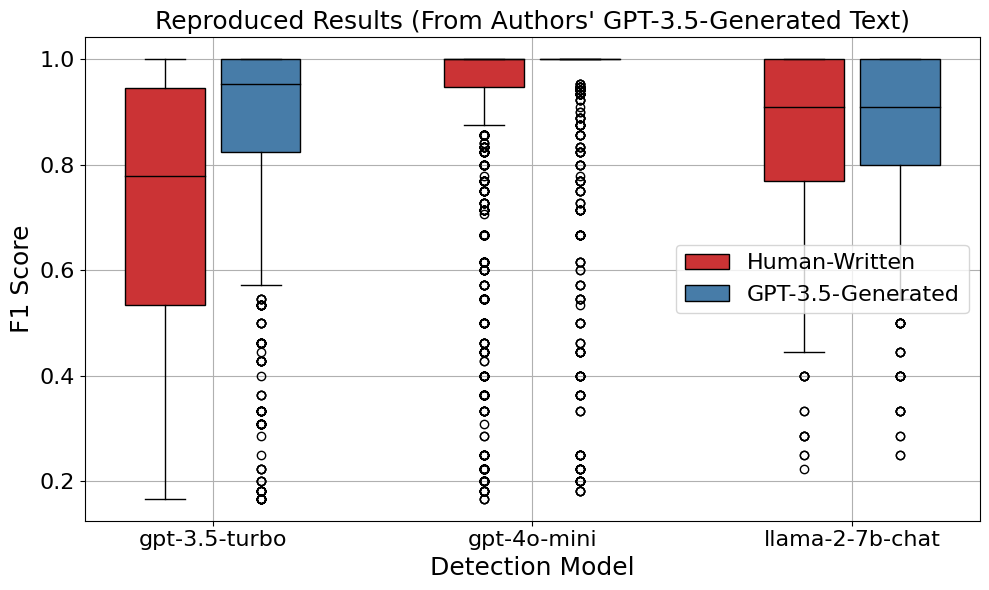

In [34]:
df_plot = df_results_agg[
    df_results_agg['experiment'] == 'original'
]

# Compute F1-scores for each model, grouping by UUID and Source Type
model2label = {
    'GPT3_5T-label_clean': 'gpt-3.5-turbo',
    'GPT4o-label_clean': 'gpt-4o-mini',
    'llama2_label_clean': 'llama-2-7b-chat'
}
models = list(model2label.keys())
results = []

for model in model2label.keys():
    f1_human = calculate_f1(
        df_plot[
            (df_plot['source_type'] == 'human') &
            df_plot[model].fillna(-1).astype(int).isin([0, 1])
        ],
        prediction_col=model,
        group_col='uuid'
    )
    f1_llm = calculate_f1(
        df_plot[
            (df_plot['source_type'] == 'LLM') &
            df_plot[model].fillna(-1).astype(int).isin([0, 1])
        ],
        prediction_col=model,
        group_col='uuid'
    )
    print(f"Model: {model}, Human F1 Count: {len(f1_human)}, LLM F1 Count: {len(f1_llm)}")
    results.append((model, 'Human-Written', f1_human))
    results.append((model, 'LLM-Generated', f1_llm))

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Model': [r[0] for r in results for _ in range(len(r[2]))],
    'Source Type': [r[1] for r in results for _ in range(len(r[2]))],
    'F1 Score': [f1 for r in results for f1 in r[2]]
})

# Filter out nans
plot_df = plot_df[
    plot_df['F1 Score'].notna()
]

# Create a boxplot for each model and source type
fig, ax = plt.subplots(figsize=(10, 6))

# Set colors for human-written and LLM-generated
colors = {'Human-Written': '#cb3335', 'LLM-Generated': '#477ca8'}

# Customizable text sizes
axis_label_size = 18
tick_label_size = 16
title_size = 18
legend_text_size = 16

# Positions for the boxplots
positions = []
human_positions = []
llm_positions = []
labels = []

# Generate the boxplots
for idx, (model, model_label) in enumerate(model2label.items()):
    model_data = plot_df[plot_df['Model'] == model]
    human_data = model_data[model_data['Source Type'] == 'Human-Written']['F1 Score']
    llm_data = model_data[model_data['Source Type'] == 'LLM-Generated']['F1 Score']
    
    # Set positions for the current model
    human_pos = idx * 2 - 0.3
    llm_pos = idx * 2 + 0.3
    human_positions.append(human_pos)
    llm_positions.append(llm_pos)
    positions.extend([human_pos, llm_pos])
    labels.append(model_label)

    # Create boxplots
    bp_human = ax.boxplot(
        [human_data],
        positions=[human_pos],
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor=colors['Human-Written'], color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="black"),
    )
    bp_llm = ax.boxplot(
        [llm_data],
        positions=[llm_pos],
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor=colors['LLM-Generated'], color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="black"),
    )

# Customize the x-axis
ax.set_xticks(np.arange(0, len(model2label) * 2, 2))
ax.set_xticklabels(labels, fontsize=tick_label_size)
ax.set_xlabel("Detection Model", fontsize=axis_label_size)
ax.set_ylabel("F1 Score", fontsize=axis_label_size)

# Customize y-axis tick labels
ax.tick_params(axis='both', labelsize=tick_label_size)

# Add a legend
legend_elements = [
    Patch(facecolor=colors['Human-Written'], edgecolor='black', label='Human-Written'),
    Patch(facecolor=colors['LLM-Generated'], edgecolor='black', label='GPT-3.5-Generated')
]
ax.legend(handles=legend_elements, fontsize=legend_text_size)

# Add a title
ax.set_title("Reproduced Results (From Authors' GPT-3.5-Generated Text)", fontsize=title_size)

plt.grid(zorder=0)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Reproduction

Model: GPT3_5T-label_clean, GPT3.5 F1 Count: 614, GPT4o F1 Count: 577, Llama2 F1 Count: 609
Model: GPT4o-label_clean, GPT3.5 F1 Count: 613, GPT4o F1 Count: 577, Llama2 F1 Count: 609
Model: llama2_label_clean, GPT3.5 F1 Count: 282, GPT4o F1 Count: 261, Llama2 F1 Count: 257


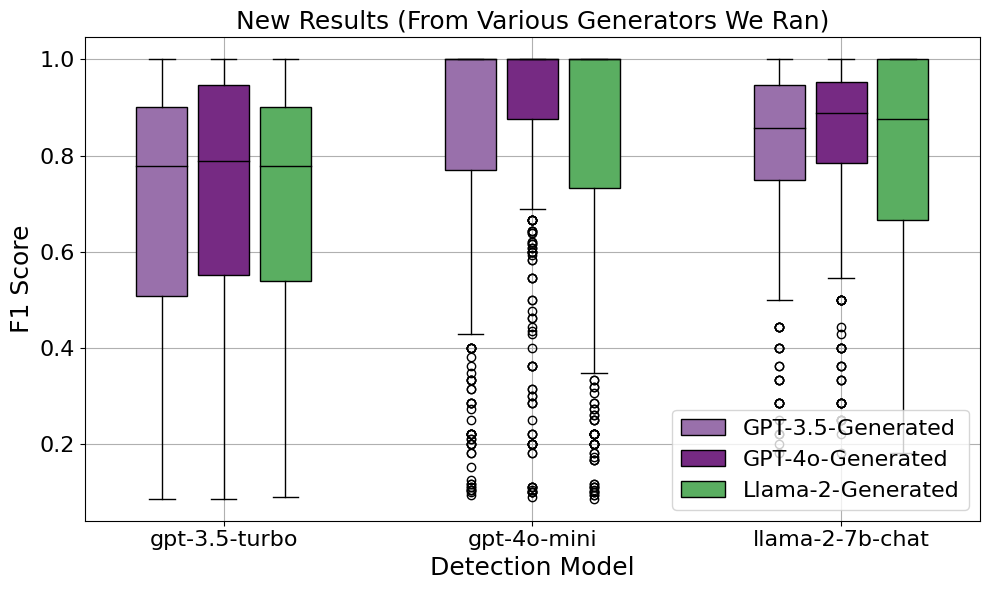

In [35]:
df_plot = df_results_agg[
    (df_results_agg['experiment'] == 'reproduction') &
    (df_results_agg['llm_type'].isin(['gpt3_5', 'gpt4o', 'llama2']))
]

# Compute F1-scores for each model, grouping by UUID and LLM Type (gpt3_5, gpt4o, llama2)
model2label = {
    'GPT3_5T-label_clean': 'gpt-3.5-turbo',
    'GPT4o-label_clean': 'gpt-4o-mini',
    'llama2_label_clean': 'llama-2-7b-chat'
}
models = list(model2label.keys())
results = []

for model in model2label.keys():
    f1_gpt3_5 = calculate_f1(
        df_plot[
            (df_plot['llm_type'] == 'gpt3_5') &
            df_plot[model].fillna(-1).astype(int).isin([0, 1])
        ],
        prediction_col=model,
        group_col='uuid'
    )
    f1_gpt4o = calculate_f1(
        df_plot[
            (df_plot['llm_type'] == 'gpt4o') &
            df_plot[model].fillna(-1).astype(int).isin([0, 1])
        ],
        prediction_col=model,
        group_col='uuid'
    )
    f1_llama2 = calculate_f1(
        df_plot[
            (df_plot['llm_type'] == 'llama2') &
            df_plot[model].fillna(-1).astype(int).isin([0, 1])
        ],
        prediction_col=model,
        group_col='uuid'
    )
    print(f"Model: {model}, GPT3.5 F1 Count: {len(f1_gpt3_5)}, GPT4o F1 Count: {len(f1_gpt4o)}, Llama2 F1 Count: {len(f1_llama2)}")
    results.append((model, 'GPT-3.5-Generated', f1_gpt3_5))
    results.append((model, 'GPT-4o-Generated', f1_gpt4o))
    results.append((model, 'Llama-2-Generated', f1_llama2))

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Model': [r[0] for r in results for _ in range(len(r[2]))],
    'Source Type': [r[1] for r in results for _ in range(len(r[2]))],
    'F1 Score': [f1 for r in results for f1 in r[2]]
})

# Filter out nans
plot_df = plot_df[
    plot_df['F1 Score'].notna()
]

# Create a boxplot for each model and source type
fig, ax = plt.subplots(figsize=(10, 6))

# Set colors for human-written and LLM-generated
colors = {
    'GPT-3.5-Generated': '#9970AB',
    'GPT-4o-Generated': '#762A83',
    'Llama-2-Generated': '#5AAE61',
}

# Customizable text sizes
axis_label_size = 18
tick_label_size = 16
title_size = 18
legend_text_size = 16

# Positions for the boxplots
positions = []
gpt3_5_positions = []
gpt4o_positions = []
llama2_positions = []
labels = []

# Generate the boxplots
for idx, (model, model_label) in enumerate(model2label.items()):
    model_data = plot_df[plot_df['Model'] == model]
    gpt3_5_data = model_data[model_data['Source Type'] == 'GPT-3.5-Generated']['F1 Score']
    gpt4o_data = model_data[model_data['Source Type'] == 'GPT-4o-Generated']['F1 Score']
    llama2_data = model_data[model_data['Source Type'] == 'Llama-2-Generated']['F1 Score']
    
    # Set positions for the current model
    gpt3_5_pos = idx * 2 - 0.4
    gpt4o_pos = idx * 2 + 0
    llama2_pos = idx * 2 + 0.4
    gpt3_5_positions.append(gpt3_5_pos)
    gpt4o_positions.append(gpt4o_pos)
    llama2_positions.append(llama2_pos)
    positions.extend([gpt3_5_pos, gpt4o_pos, llama2_pos])
    labels.append(model_label)

    # Create boxplots
    bp_gpt3_5 = ax.boxplot(
        [gpt3_5_data],
        positions=[gpt3_5_pos],
        widths=0.33,
        patch_artist=True,
        boxprops=dict(facecolor=colors['GPT-3.5-Generated'], color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="black"),
    )
    bp_gpt4o = ax.boxplot(
        [gpt4o_data],
        positions=[gpt4o_pos],
        widths=0.33,
        patch_artist=True,
        boxprops=dict(facecolor=colors['GPT-4o-Generated'], color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="black"),
    )
    bp_llama2 = ax.boxplot(
        [llama2_data],
        positions=[llama2_pos],
        widths=0.33,
        patch_artist=True,
        boxprops=dict(facecolor=colors['Llama-2-Generated'], color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="black"),
    )

# Customize the x-axis
ax.set_xticks(np.arange(0, len(model2label) * 2, 2))
ax.set_xticklabels(labels, fontsize=tick_label_size)
ax.set_xlabel("Detection Model", fontsize=axis_label_size)
ax.set_ylabel("F1 Score", fontsize=axis_label_size)

# Customize y-axis tick labels
ax.tick_params(axis='both', labelsize=tick_label_size)

# Add a legend
legend_elements = [
    Patch(facecolor=colors['GPT-3.5-Generated'], edgecolor='black', label='GPT-3.5-Generated'),
    Patch(facecolor=colors['GPT-4o-Generated'], edgecolor='black', label='GPT-4o-Generated'),
    Patch(facecolor=colors['Llama-2-Generated'], edgecolor='black', label='Llama-2-Generated')
]
ax.legend(handles=legend_elements, fontsize=legend_text_size, loc='lower right')

# Add a title
ax.set_title("New Results (From Various Generators We Ran)", fontsize=title_size)

plt.grid(zorder=0)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Articles vs Posts

### Original: GPT-3.5 generated

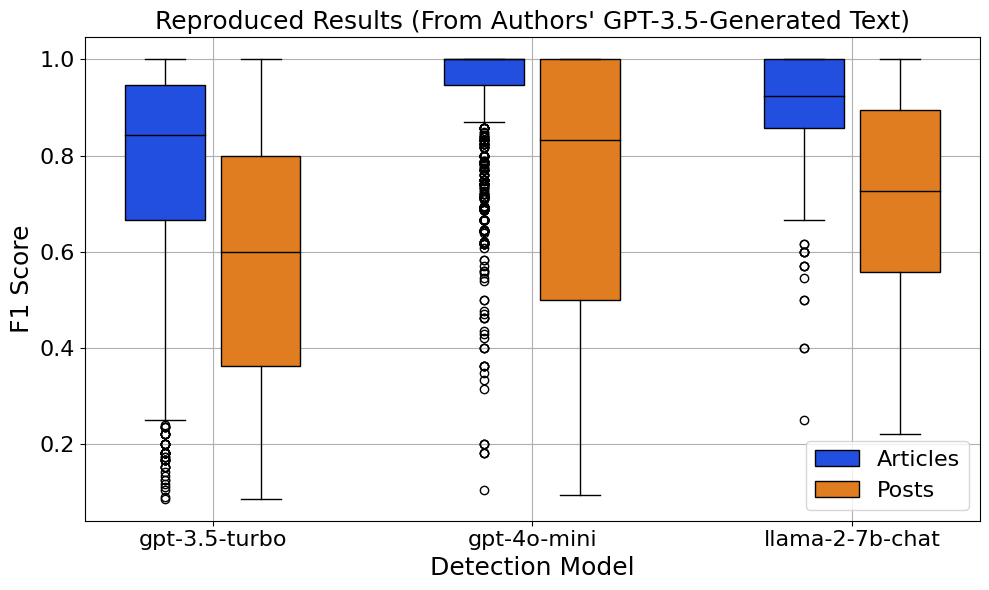

In [36]:
df_plot = df_results_agg[
    df_results_agg['experiment'] == 'original'
]

# Compute F1-scores for each model, grouping by UUID and Source Type
model2label = {
    'GPT3_5T-label_clean': 'gpt-3.5-turbo',
    'GPT4o-label_clean': 'gpt-4o-mini',
    'llama2_label_clean': 'llama-2-7b-chat'
}
models = list(model2label.keys())
results = []

for model in model2label.keys():
    f1_articles = calculate_f1(
        df_plot[
            (df_plot['article_type'] == 'news article') &
            df_plot[model].fillna(-1).astype(int).isin([0, 1])
        ],
        prediction_col=model,
        group_col='uuid'
    )
    f1_posts = calculate_f1(
        df_plot[
            (df_plot['article_type'] == 'twitter post') &
            df_plot[model].fillna(-1).astype(int).isin([0, 1])
        ],
        prediction_col=model,
        group_col='uuid'
    )
    # print(f"Model: {model}, Human F1 Count: {len(f1_human)}, LLM F1 Count: {len(f1_llm)}")
    results.append((model, 'Articles', f1_articles))
    results.append((model, 'Posts', f1_posts))

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Model': [r[0] for r in results for _ in range(len(r[2]))],
    'Source Type': [r[1] for r in results for _ in range(len(r[2]))],
    'F1 Score': [f1 for r in results for f1 in r[2]]
})

# Filter out nans
plot_df = plot_df[
    plot_df['F1 Score'].notna()
]

# Create a boxplot for each model and source type
fig, ax = plt.subplots(figsize=(10, 6))

# Set colors for human-written and LLM-generated
colors = {'Articles': '#224fdf', 'Posts': '#df7d20'}

# Customizable text sizes
axis_label_size = 18
tick_label_size = 16
title_size = 18
legend_text_size = 16

# Positions for the boxplots
positions = []
articles_positions = []
posts_positions = []
labels = []

# Generate the boxplots
for idx, (model, model_label) in enumerate(model2label.items()):
    model_data = plot_df[plot_df['Model'] == model]
    articles_data = model_data[model_data['Source Type'] == 'Articles']['F1 Score']
    posts_data = model_data[model_data['Source Type'] == 'Posts']['F1 Score']
    
    # Set positions for the current model
    articles_pos = idx * 2 - 0.3
    posts_pos = idx * 2 + 0.3
    articles_positions.append(articles_pos)
    posts_positions.append(posts_pos)
    positions.extend([articles_pos, posts_pos])
    labels.append(model_label)

    # Create boxplots
    bp_articles = ax.boxplot(
        [articles_data],
        positions=[articles_pos],
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor=colors['Articles'], color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="black"),
    )
    bp_posts = ax.boxplot(
        [posts_data],
        positions=[posts_pos],
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor=colors['Posts'], color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="black"),
    )

# Customize the x-axis
ax.set_xticks(np.arange(0, len(model2label) * 2, 2))
ax.set_xticklabels(labels, fontsize=tick_label_size)
ax.set_xlabel("Detection Model", fontsize=axis_label_size)
ax.set_ylabel("F1 Score", fontsize=axis_label_size)

# Customize y-axis tick labels
ax.tick_params(axis='both', labelsize=tick_label_size)

# Add a legend
legend_elements = [
    Patch(facecolor=colors['Articles'], edgecolor='black', label='Articles'),
    Patch(facecolor=colors['Posts'], edgecolor='black', label='Posts')
]
ax.legend(handles=legend_elements, fontsize=legend_text_size)

# Add a title
ax.set_title("Reproduced Results (From Authors' GPT-3.5-Generated Text)", fontsize=title_size)

plt.grid(zorder=0)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### New: GPT-3.5 generated

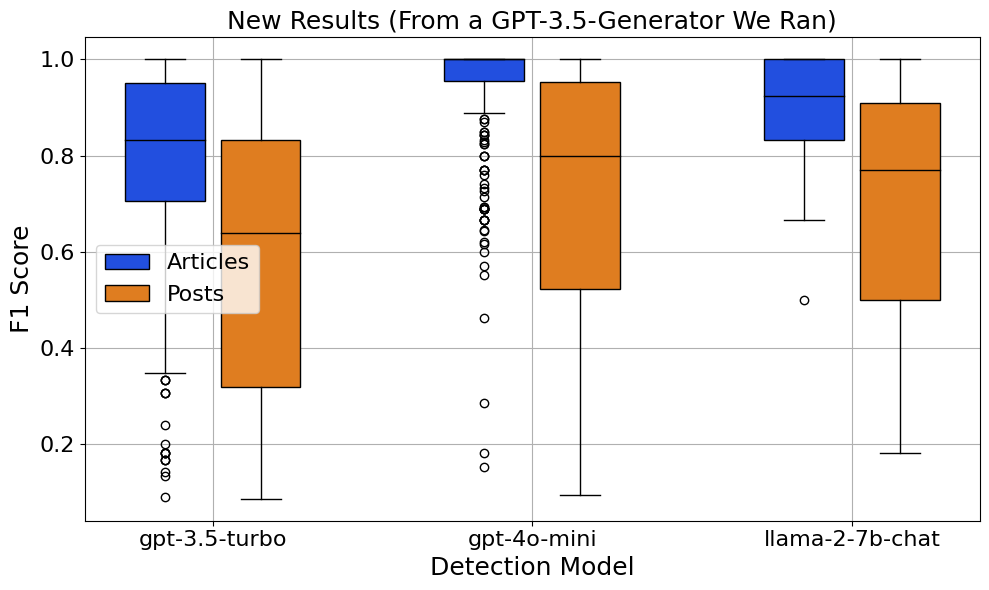

In [37]:
df_plot = df_results_agg[
    (df_results_agg['experiment'] == 'reproduction') &
    (df_results_agg['llm_type'] == 'gpt3_5')
]

# Compute F1-scores for each model, grouping by UUID and Source Type
model2label = {
    'GPT3_5T-label_clean': 'gpt-3.5-turbo',
    'GPT4o-label_clean': 'gpt-4o-mini',
    'llama2_label_clean': 'llama-2-7b-chat'
}
models = list(model2label.keys())
results = []

for model in model2label.keys():
    f1_articles = calculate_f1(
        df_plot[
            (df_plot['article_type'] == 'news article') &
            df_plot[model].fillna(-1).astype(int).isin([0, 1])
        ],
        prediction_col=model,
        group_col='uuid'
    )
    f1_posts = calculate_f1(
        df_plot[
            (df_plot['article_type'] == 'twitter post') &
            df_plot[model].fillna(-1).astype(int).isin([0, 1])
        ],
        prediction_col=model,
        group_col='uuid'
    )
    # print(f"Model: {model}, Human F1 Count: {len(f1_human)}, LLM F1 Count: {len(f1_llm)}")
    results.append((model, 'Articles', f1_articles))
    results.append((model, 'Posts', f1_posts))

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Model': [r[0] for r in results for _ in range(len(r[2]))],
    'Source Type': [r[1] for r in results for _ in range(len(r[2]))],
    'F1 Score': [f1 for r in results for f1 in r[2]]
})

# Filter out nans
plot_df = plot_df[
    plot_df['F1 Score'].notna()
]

# Create a boxplot for each model and source type
fig, ax = plt.subplots(figsize=(10, 6))

# Set colors for human-written and LLM-generated
colors = {'Articles': '#224fdf', 'Posts': '#df7d20'}

# Customizable text sizes
axis_label_size = 18
tick_label_size = 16
title_size = 18
legend_text_size = 16

# Positions for the boxplots
positions = []
articles_positions = []
posts_positions = []
labels = []

# Generate the boxplots
for idx, (model, model_label) in enumerate(model2label.items()):
    model_data = plot_df[plot_df['Model'] == model]
    articles_data = model_data[model_data['Source Type'] == 'Articles']['F1 Score']
    posts_data = model_data[model_data['Source Type'] == 'Posts']['F1 Score']
    
    # Set positions for the current model
    articles_pos = idx * 2 - 0.3
    posts_pos = idx * 2 + 0.3
    articles_positions.append(articles_pos)
    posts_positions.append(posts_pos)
    positions.extend([articles_pos, posts_pos])
    labels.append(model_label)

    # Create boxplots
    bp_articles = ax.boxplot(
        [articles_data],
        positions=[articles_pos],
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor=colors['Articles'], color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="black"),
    )
    bp_posts = ax.boxplot(
        [posts_data],
        positions=[posts_pos],
        widths=0.5,
        patch_artist=True,
        boxprops=dict(facecolor=colors['Posts'], color="black"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        medianprops=dict(color="black"),
    )

# Customize the x-axis
ax.set_xticks(np.arange(0, len(model2label) * 2, 2))
ax.set_xticklabels(labels, fontsize=tick_label_size)
ax.set_xlabel("Detection Model", fontsize=axis_label_size)
ax.set_ylabel("F1 Score", fontsize=axis_label_size)

# Customize y-axis tick labels
ax.tick_params(axis='both', labelsize=tick_label_size)

# Add a legend
legend_elements = [
    Patch(facecolor=colors['Articles'], edgecolor='black', label='Articles'),
    Patch(facecolor=colors['Posts'], edgecolor='black', label='Posts')
]
ax.legend(handles=legend_elements, fontsize=legend_text_size)

# Add a title
ax.set_title("New Results (From a GPT-3.5-Generator We Ran)", fontsize=title_size)

plt.grid(zorder=0)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [38]:
df_results_agg[:3]

,uuid,content,label,Prompt_type,pre_post_GPT,article_type,dataset_source,source_type,detection_seed,experiment,preamble,GPT3_5T-label_clean,GPT4o-label_clean,llama2_label_clean,llama3_label_clean,mixtral_label_clean,llm_type
0,00195688-2401-4c51-b8e3-e39ed3c7ff5a,Here is the factual content and key points of ...,1,A_CoT,pre-GPT,twitter post,x-Gen,LLM,0,reproduction,1,1.0,1.0,NaN,NaN,NaN,llama2
1,00195688-2401-4c51-b8e3-e39ed3c7ff5a,Here is the factual content and key points of ...,1,A_Con,pre-GPT,twitter post,x-Gen,LLM,0,reproduction,1,1.0,1.0,NaN,NaN,NaN,llama2
2,00195688-2401-4c51-b8e3-e39ed3c7ff5a,Here is the factual content and key points of ...,1,Analyze_AI_GPT,pre-GPT,twitter post,x-Gen,LLM,0,reproduction,1,1.0,1.0,NaN,NaN,NaN,llama2


## Prompt Types

In [82]:
shared_columns = [
    'uuid', 'content', 'label', 'Prompt_type', 'pre_post_GPT',
    'article_type', 'dataset_source', 'source_type', 'detection_seed',
    'experiment', 'preamble', 'Prompt_type_severity', 'llm_type'
]
df_results_unpivot = pd.concat([
    df_results_agg.rename(columns={
        'GPT3_5T-label_clean': 'pred'
    })[shared_columns + ['pred']].assign(model='GPT-3.5-Turbo'),
    df_results_agg.rename(columns={
        'GPT4o-label_clean': 'pred'
    })[shared_columns + ['pred']].assign(model='GPT-4o-Mini'),
    df_results_agg.rename(columns={
        'llama2_label_clean': 'pred'
    })[shared_columns + ['pred']].assign(model='Llama-2-7b'),
])
print(df_results_unpivot.shape)
df_results_unpivot[:1]

(295800, 15)


,uuid,content,label,Prompt_type,pre_post_GPT,article_type,dataset_source,source_type,detection_seed,experiment,preamble,Prompt_type_severity,llm_type,pred,model
0,00195688-2401-4c51-b8e3-e39ed3c7ff5a,Here is the factual content and key points of ...,1,A_CoT,pre-GPT,twitter post,x-Gen,LLM,0,reproduction,1,critical,llama2,1.0,GPT-3.5-Turbo


In [ ]:
# df_results_unpivot[:10000].to_excel('temp.xlsx', index=False)

In [107]:
# Define a function to calculate F1-scores for a given group
def calculate_f1_scores(group, pred_col='pred', true_col='label'):
    group_ = group[
        group[true_col].fillna(-1).astype(int).isin([0, 1]) &
        group[pred_col].fillna(-1).astype(int).isin([0, 1])
    ]
    true_labels = group_[true_col].astype(int)
    pred_labels = group_[pred_col].astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='macro', zero_division=0
    )
    return f1

# Filter out rows with NaN values in the prediction column
df_sample_filtered = df_results_unpivot.dropna(subset=['pred'])

# Group by the required columns
grouped_filtered = df_sample_filtered.groupby(
    [
        'experiment', 'llm_type', 'model',
        'pre_post_GPT', 'Prompt_type', 'article_type', 'Prompt_type_severity',
    ]
)

# Calculate F1-scores for the filtered groups
results_filtered = []
for name, group in grouped_filtered:
    f1_human = calculate_f1_scores(group, pred_col='label', true_col='label')  # Human F1
    f1_llm = calculate_f1_scores(group, pred_col='pred', true_col='label')    # LLM F1
    results_filtered.append(name + (f1_human, f1_llm))

# Create a DataFrame for the filtered results
columns_filtered = [
    'experiment', 'llm_type', 'model',
    'pre_post_GPT', 'Prompt_type', 'article_type', 'Prompt_type_severity',
    'F1_Human', 'F1_LLM',
]
df_repr_table = pd.DataFrame(results_filtered, columns=columns_filtered)

df_repr_table = df_repr_table.drop(columns=['F1_Human'])
df_repr_table = df_repr_table.rename(columns={
    'Prompt_type': 'prompt'
})

# Pivot
df_repr_table = df_repr_table.pivot(
    index=[
        'experiment', 'llm_type',
        'pre_post_GPT', 'model', 'article_type', 'prompt',
    ],
    columns='Prompt_type_severity',
    values='F1_LLM',
).reset_index()
df_repr_table = df_repr_table.rename(columns={
    'critical': 'LLM-Crit',
    'major': 'LLM-Min',
    'minor': 'LLM-Maj',
})
df_repr_table = df_repr_table[[
    'experiment', 'llm_type',
    'pre_post_GPT', 'model', 'article_type', 'prompt',
    'LLM-Min', 'LLM-Maj', 'LLM-Crit',
]]

print(df_repr_table.shape)
df_repr_table[:3]

(528, 9)


Prompt_type_severity,experiment,llm_type,pre_post_GPT,model,article_type,prompt,LLM-Min,LLM-Maj,LLM-Crit
0,original,gpt3_5,post-GPT,GPT-3.5-Turbo,news article,A_CoT,0.881944,1.000000,NaN
1,original,gpt3_5,post-GPT,GPT-3.5-Turbo,news article,A_Con,0.873016,0.666667,NaN
2,original,gpt3_5,post-GPT,GPT-3.5-Turbo,news article,Analyze_AI_GPT,0.625000,0.733333,NaN


In [121]:
pd.crosstab(
    df_repr_table['experiment'],
    df_repr_table['llm_type']
)

llm_type,gpt3_5,gpt4o,llama2
experiment,,,
original,132,0,0
reproduction,132,132,132


In [44]:
df_f3_table = pd.read_excel('f3_tables.xlsx')
print(df_f3_table.shape)
df_f3_table[:3]

(80, 8)


,pre_post_GPT,model,article_type,prompt,Human,LLM-Min,LLM-Maj,LLM-Crit
0,pre-GPT,GPT-3.5-Turbo,news article,VaN,0.6761,0.7676,0.7753,0.7886
1,pre-GPT,GPT-3.5-Turbo,news article,Z-CoT,0.6823,0.7491,0.7944,0.8027
2,pre-GPT,GPT-3.5-Turbo,news article,X-CoT,0.6694,0.8220,0.8393,0.8470


In [153]:
prompt_order = [
    'VaN',
    'Z-CoT',
    'Z_CoT',
    'A-CoT',
    'A_CoT',
    'X-CoT',
    'X_CoT',
    # 'A-CoN',
    'MsReN',
    'MSReN',
    'MSReN_paper',
    'MsReN_CoT',
    'DeF_Gen',
    'DeF_SpeC',
    'Analyze_Cld2',
    'Analyze_AI_GPT',
]

### Pre-GPT, GPT-3.5 Turbo Generator

#### Reported

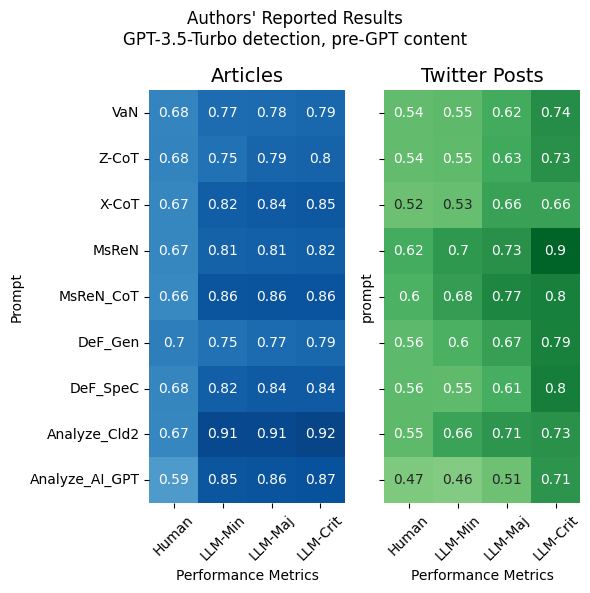

In [154]:
# Filter data for pre-GPT and GPT-3.5-Turbo model
df_plot = df_f3_table[
    (df_f3_table['pre_post_GPT'] == 'pre-GPT') &
    (df_f3_table['model'] == 'GPT-3.5-Turbo')
]

# Separate articles and twitter posts
df_articles = df_plot[df_plot['article_type'] == 'news article'][['prompt', 'Human', 'LLM-Min', 'LLM-Maj', 'LLM-Crit']]
df_posts = df_plot[df_plot['article_type'] == 'twitter post'][['prompt', 'Human', 'LLM-Min', 'LLM-Maj', 'LLM-Crit']]

# Set the prompt as index for easier heatmap plotting
df_articles.set_index('prompt', inplace=True)
df_posts.set_index('prompt', inplace=True)

df_articles = df_articles.loc[[col for col in prompt_order if col in df_articles.index]]
df_posts = df_posts.loc[[col for col in prompt_order if col in df_posts.index]]

# Plot heatmap for articles (left) and twitter posts (right)
fig, axes = plt.subplots(1, 2, figsize=(6, 6), sharey=True)

# Heatmap for articles
sns.heatmap(df_articles, annot=True, vmin=0, vmax=1, cmap="Blues", ax=axes[0], cbar=False)
axes[0].set_title("Articles", fontsize=14)
axes[0].set_ylabel("Prompt")
axes[0].set_xlabel("Performance Metrics")
for tick in axes[0].get_xticklabels():
    tick.set_rotation(45)

# Heatmap for twitter posts
sns.heatmap(df_posts, annot=True, vmin=0, vmax=1, cmap="Greens", ax=axes[1], cbar=False)
axes[1].set_title("Twitter Posts", fontsize=14)
axes[1].set_xlabel("Performance Metrics")
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)

plt.suptitle("Authors' Reported Results\nGPT-3.5-Turbo detection, pre-GPT content")
plt.tight_layout()
plt.show()

#### Reproduction with their generations

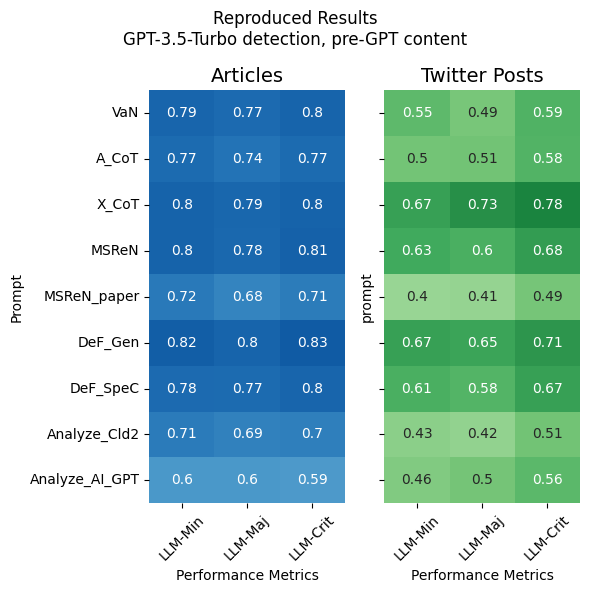

In [152]:
# Filter data for pre-GPT and GPT-3.5-Turbo model
df_plot = df_repr_table[
    (df_repr_table['experiment'] == 'original') &
    (df_repr_table['pre_post_GPT'] == 'pre-GPT') &
    (df_repr_table['model'] == 'GPT-3.5-Turbo')
]

# Separate articles and twitter posts
df_articles = df_plot[df_plot['article_type'] == 'news article'][['prompt', 'LLM-Min', 'LLM-Maj', 'LLM-Crit']]
df_posts = df_plot[df_plot['article_type'] == 'twitter post'][['prompt', 'LLM-Min', 'LLM-Maj', 'LLM-Crit']]

# Set the prompt as index for easier heatmap plotting
df_articles.set_index('prompt', inplace=True)
df_posts.set_index('prompt', inplace=True)

df_articles = df_articles.loc[[col for col in prompt_order if col in df_articles.index]]
df_posts = df_posts.loc[[col for col in prompt_order if col in df_posts.index]]

# Plot heatmap for articles (left) and twitter posts (right)
fig, axes = plt.subplots(1, 2, figsize=(6, 6), sharey=True)

# Heatmap for articles
sns.heatmap(df_articles, annot=True, vmin=0, vmax=1, cmap="Blues", ax=axes[0], cbar=False)
axes[0].set_title("Articles", fontsize=14)
axes[0].set_ylabel("Prompt")
axes[0].set_xlabel("Performance Metrics")
for tick in axes[0].get_xticklabels():
    tick.set_rotation(45)

# Heatmap for twitter posts
sns.heatmap(df_posts, annot=True, vmin=0, vmax=1, cmap="Greens", ax=axes[1], cbar=False)
axes[1].set_title("Twitter Posts", fontsize=14)
axes[1].set_xlabel("Performance Metrics")
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)

plt.suptitle("Reproduced Results\nGPT-3.5-Turbo detection, pre-GPT content")
plt.tight_layout()
plt.show()

#### Reproduction with our generations

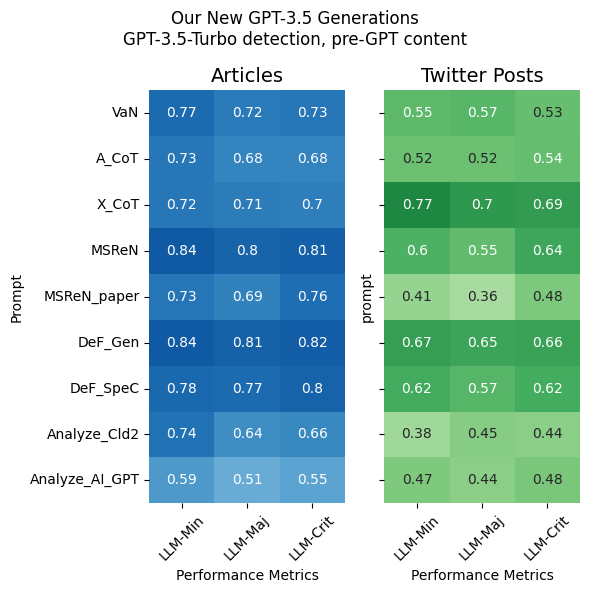

In [155]:
# Filter data for pre-GPT and GPT-3.5-Turbo model
df_plot = df_repr_table[
    (df_repr_table['experiment'] == 'reproduction') &
    (df_repr_table['llm_type'] == 'gpt3_5') &
    (df_repr_table['pre_post_GPT'] == 'pre-GPT') &
    (df_repr_table['model'] == 'GPT-3.5-Turbo')
]

# Separate articles and twitter posts
df_articles = df_plot[df_plot['article_type'] == 'news article'][['prompt', 'LLM-Min', 'LLM-Maj', 'LLM-Crit']]
df_posts = df_plot[df_plot['article_type'] == 'twitter post'][['prompt', 'LLM-Min', 'LLM-Maj', 'LLM-Crit']]

# Set the prompt as index for easier heatmap plotting
df_articles.set_index('prompt', inplace=True)
df_posts.set_index('prompt', inplace=True)

df_articles = df_articles.loc[[col for col in prompt_order if col in df_articles.index]]
df_posts = df_posts.loc[[col for col in prompt_order if col in df_posts.index]]

# Plot heatmap for articles (left) and twitter posts (right)
fig, axes = plt.subplots(1, 2, figsize=(6, 6), sharey=True)

# Heatmap for articles
sns.heatmap(df_articles, annot=True, vmin=0, vmax=1, cmap="Blues", ax=axes[0], cbar=False)
axes[0].set_title("Articles", fontsize=14)
axes[0].set_ylabel("Prompt")
axes[0].set_xlabel("Performance Metrics")
for tick in axes[0].get_xticklabels():
    tick.set_rotation(45)

# Heatmap for twitter posts
sns.heatmap(df_posts, annot=True, vmin=0, vmax=1, cmap="Greens", ax=axes[1], cbar=False)
axes[1].set_title("Twitter Posts", fontsize=14)
axes[1].set_xlabel("Performance Metrics")
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)

plt.suptitle("Our New GPT-3.5 Generations\nGPT-3.5-Turbo detection, pre-GPT content")
plt.tight_layout()
plt.show()

In [42]:
df_results_agg['pre_post_GPT'].value_counts()

pre_post_GPT
pre-GPT     93221
post-GPT     5379
Name: count, dtype: int64

In [ ]:
df_results_agg[
    (df_results_agg['experiment'] == 'reproduction') &
    (df_results_agg['Prompt_type'] == 'MsReN') &
    (df_results_
]

In [40]:
df_results_agg.columns

Index(['uuid', 'content', 'label', 'Prompt_type', 'pre_post_GPT',
       'article_type', 'dataset_source', 'source_type', 'detection_seed',
       'experiment', 'preamble', 'GPT3_5T-label_clean', 'GPT4o-label_clean',
       'llama2_label_clean', 'llama3_label_clean', 'mixtral_label_clean',
       'llm_type'],
      dtype='object')

- TODO Macro-F1 score of GPT-3.5, GPT-4o, Llama2 disinformation detection
  - DONE Fig 4 average results of above models on original GPT-3.5 generations
  - DONE Similar plot for each of new GPT-3.5, GPT-4o, Llama2 generations
  - DONE Break down performance by articles and social media
  - TODO Break down by human disinformation, minor, major, critical prompts
  - TODO Break down into pre- and post-GPT topics
  - TODO Table 11, break down performance by article vs posts, detection model, and detection prompt.